In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings
using Printf

In [2]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [3]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [4]:
moon     = plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [5]:
function interpolatecolor(cs,value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [27]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename1 = "../run/data/diffcorr_0618_velThrust.csv"
filename2 = "../run/data/diffcorr_0618_maxJCThrust2.csv"
filename3 = "../run/data/diffcorr_0619_EMrotThrust2.csv"
filename4 = "../run/data/diffcorr_0619_NoThrust2.csv"
filename5 = "../run/data/diffcorr_0717_TidalThrust.csv"

# dv_dir function corresponding to the csv file 
# dir_func = SailorMoon.dv_EMrotdir_sb1frame
# dir_func = SailorMoon.dv_vel_dir_sb1frame
# dir_func = SailorMoon.dv_maxJC_dir_sb1frame
dir_func = SailorMoon.dv_tidal_dir_sb1frame
# dir_func = SailorMoon.dv_no_thrust


n_arc = 5

cs = :lightrainbow 
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df1 = CSV.read(filename1, DataFrame; header=0);
df2 = CSV.read(filename2, DataFrame; header=0);
df3 = CSV.read(filename3, DataFrame; header=0);
df4 = CSV.read(filename4, DataFrame; header=0);
df5 = CSV.read(filename5, DataFrame; header=0);

if dir_func == SailorMoon.dv_vel_dir_sb1frame
    df = df1
elseif dir_func == SailorMoon.dv_maxJC_dir_sb1frame
    df = df2
elseif dir_func == SailorMoon.dv_EMrotdir_sb1frame
    df = df3
elseif dir_func == SailorMoon.dv_no_thrust
    df = df4
elseif dir_func == SailorMoon.dv_tidal_dir_sb1frame
    df = df5
end


arcs_color = Dict(
    "xlr_bck_arc" => :blue, 
    "xlr_fwd_arc" => :blue,
    "mid_bck_arc" => :blue, 
    "mid_fwd_arc" => :blue, 
    "lpo_arc" => :blue
)


pcart = plot(
    size=(600,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs, xlim = [-2e6, 2e6], ylim = [-2e6, 2e6],
    fontsize=fs, xlabelfontsize=fs+1, ylabelfontsize=fs+1, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

p_time = plot(
    size=(700,500), frame_style=:box, grid=0.4, legend=false, 
    xlabel=L"time, s", ylabel=L"value",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

In [28]:

tofs1 = [row[2] for row in eachrow( df1 ) ] 
tofs2 = [row[2] for row in eachrow( df2 ) ] 
tofs3 = [row[2] for row in eachrow( df3 ) ] 
tofs4 = [row[2] for row in eachrow( df4 ) ] 
tofs5 = [row[2] for row in eachrow( df4 ) ] 


tof_max = maximum(vcat(tofs1, tofs2, tofs3, tofs4, tofs5))
tof_min = minimum(vcat(tofs1, tofs2, tofs3, tofs4, tofs5))

tof_max_days = tof_max * param3b.tstar / (24*60*60)
tof_min_days = tof_min * param3b.tstar / (24*60*60)

@printf("tof max: %3.1f days \n", tof_max_days)
@printf("tof min: %3.1f days", tof_min_days)

tof max: 120.4 days 
tof min: 46.7 days

In [29]:
tof_min = 45  * (24*60*60) / param3b.tstar
tof_max = 125 * (24*60*60) / param3b.tstar

colors = [interpolatecolor(cs, row[2], tof_min, tof_max) for row in eachrow(df)]

for (i, row) in enumerate( eachrow( df ) ) 
    
    x = collect(values(row[4:end]))
#     println(x)
    
    color = colors[i]
#     println(typeof(x))
    res, sol_param_list, sols_ballistic, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false, false)

    # ballistic legs
    for sol_ballistic in sols_ballistic
#         plot!(pcart, (hcat(sol_ballistic.u...)[1,:].- param3b.as) .* param3b.lstar, hcat(sol_ballistic.u...)[2,:].*param3b.lstar, c="blue", label=false)
        plot!(pcart, (hcat(sol_ballistic.u...)[1,:].- param3b.as) .* param3b.lstar, 
            hcat(sol_ballistic.u...)[2,:].*param3b.lstar, lw=0.5, c=color, label=false)

        if i == 1
#             println(length(sol[7,:]))
#             println(sol[7,:])
#             println(sol.t)
            scatter!(p_time, sol_ballistic.t[:],  sol_ballistic[7,:])
        end
   
    end
    
    for j = 1:length(sol_param_list)
        sol, _, name = sol_param_list[j]
        
#         plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c="blue")  
#         if ther is one trajectory, set a color manually
        plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, lw=0.5, c=color)
        
#         plot!(pcart, sol[1,:], sol[2,:], c=color)
#         scatter!(pcart, [sol[1,1],sol[1,end]], [sol[2,1],sol[2,end]], label=false, c=arcs_color[name], marker=:circle)
        
        if i == 1
#             println(length(sol[7,:]))
#             println(sol[7,:])
#             println(sol.t)
            scatter!(p_time, sol.t[:],  sol[7,:])
        end
        
    end
    
end


plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6; digits=1))),
);


muS = 3.003480642487067e-06 # mu
# scatter!(pcart, [-0.01+muS, 0.01].*(param3b.lstar*param3b.as), [0.0,0.0], 
#     c=:black, markersize=5, markershape=:diamond, markerstrokewidth=0.4)



3.003480642487067e-6

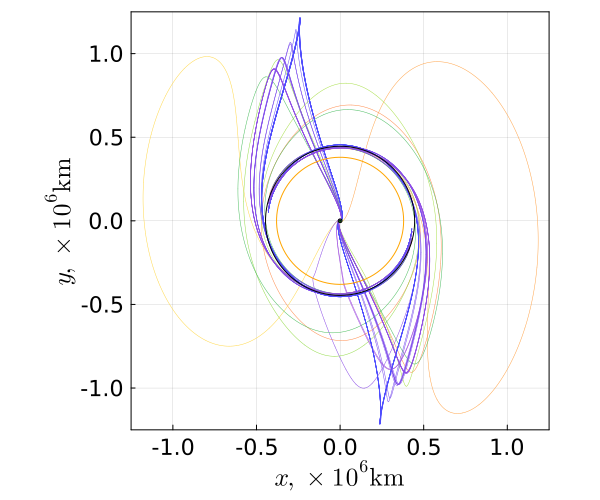

In [30]:
plot!(pcart;dpi=600, gridlinewidth=0.2)
plot!(pcart; xlim=[-1.25e6, 1.25e6], ylim=[-1.25e6, 1.25e6])

In [26]:
savefig(pcart,"diffcorr_maxJC.png")
savefig(pcart,"diffcorr_maxJC.svg")

"C:\\Users\\yujit\\Documents\\github\\SailorMoon.jl\\tests_yuji\\diffcorr_maxJC.svg"

In [ ]:
p_time

In [ ]:
a =[1,0,0]
typeof(a) == Vector{Int}
float(a)

In [ ]:
row = a[2]

### Focus on the vicinity to the Earth 

In [ ]:
plot!(pcart; xlims=[-0.05, 0.05].*10^6, ylims=[-0.05,0.05].*10^6)


In [ ]:
plot!(pcart; xlim=[-1.2e6, 1.2e6])

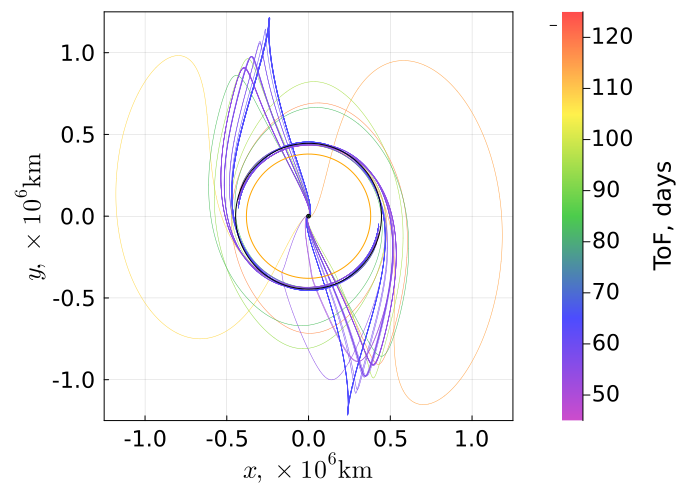

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [34]:
l = @layout [a{0.88w} b{0.01w}]

p2 = heatmap(rand(2,2), clims=(45, 125),
    framestyle=:none, c=cs, cbar=true, lims=(-1,0), colorbar_title="\nToF, days",
    colorbar_titlefontsize=fs,
    colorbar_tickfontsize=fs-1,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1,
    thickness_scaling = 1.6,
    )

plot(pcart, p2, layout=l, size=(700,500), 
#     top_margin=5Plots.mm,
#     right_margin=5Plots.mm,
#     left_margin=5Plots.mm, 
    bottom_margin=5Plots.mm, 
#     title=["No thrust" "Earth-Moon rotating thrust" ""]
    )

# savefig("traj_family.png")


In [35]:
# plot!(pcart;dpi=600, gridlinewidth=0.2)

savefig("diffcorr_tidal.png")
savefig("diffcorr_tidal.svg")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"C:\\Users\\yujit\\Documents\\github\\SailorMoon.jl\\tests_yuji\\diffcorr_tidal.svg"